### Third version of the sentiment analysis model.
- Lower sized dataset


In [14]:
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [84]:
#df_columns = ['sentiment'text']
#df_encoding = 'ISO-8859-1'
#df = pd.read_csv('/Users/User/Desktop/SA/trainer.csv',encoding=df_encoding,names=df_columns)

In [15]:
df = pd.read_csv('/Users/User/Desktop/SA/trainer.csv')

In [17]:
n = 200000
df = df.sample(n)

In [18]:
df['sentiment'].value_counts()

sentiment
1    100049
0     99951
Name: count, dtype: int64

In [89]:
# Defining regex patterns

urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

   

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [157]:
#df['processed_text'] = df.text.apply(preprocess_apply)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_data, y_data = np.array(df['processed_text']), np.array(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [21]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [22]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 15514


In [23]:
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
vocab_length = 16000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 16000


In [25]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (190000, 60)
X_test.shape : (10000, 60)


#### Embedding Matrix

In [26]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (16000, 100)


In [38]:
word2vec_model.wv.most_similar('afternoon')

[('evening', 0.8932798504829407),
 ('morning', 0.8372949957847595),
 ('weekend', 0.7303396463394165),
 ('morn', 0.7205386757850647),
 ('wknd', 0.7081730365753174),
 ('mornin', 0.6900078654289246),
 ('session', 0.6299349069595337),
 ('meeting', 0.617902398109436),
 ('week', 0.6022816300392151),
 ('semester', 0.6005880832672119)]

### LSTM

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense
from keras.metrics import Precision

def getModel():
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ],
    name="Sentiment_Model")
    
    return model


In [40]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           1600000   
                                                                 
 lstm (LSTM)                 (None, 60, 100)           80400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           50100     
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                   

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [43]:
#training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
167/167 [==============================] - 892s 5s/step - loss: 0.5422 - accuracy: 0.7223 - val_loss: 0.4823 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 2/12
167/167 [==============================] - 1180s 7s/step - loss: 0.4861 - accuracy: 0.7645 - val_loss: 0.4630 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 3/12
167/167 [==============================] - 1198s 7s/step - loss: 0.4697 - accuracy: 0.7747 - val_loss: 0.4534 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 4/12
167/167 [==============================] - 1150s 7s/step - loss: 0.4595 - accuracy: 0.7815 - val_loss: 0.4439 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 5/12
167/167 [==============================] - 942s 6s/step - loss: 0.4494 - accuracy: 0.7871 - val_loss: 0.4412 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 6/12
167/167 [==============================] - 967s 6s/step - loss: 0.4435 - accuracy: 0.7905 - val_loss: 0.4351 - val_accuracy: 0.7974 - lr: 0.0010
Epoch 7/12
167/167 [==============================] - 942s 6s

### Model Evaluation

In [100]:
score = training_model.evaluate(X_test,y_test,1024)
print('ACCURACY: ', score[1])
print('LOSS: ', score[0])

acc=score[1] * 100
loss=score[0] * 100



10/10 [==============================] - 10s 1s/step - loss: 0.4344 - accuracy: 0.7982
ACCURACY:  0.7982000112533569
LOSS:  0.43439269065856934


In [101]:
print (acc)

79.8200011253357


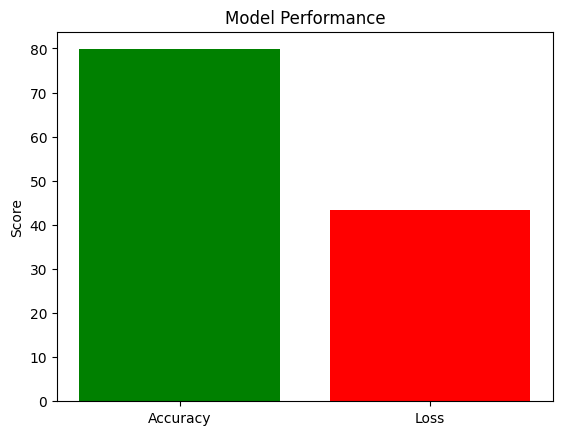

In [103]:
categories = ['Accuracy', 'Loss']
values = [acc,loss]
plt.bar(categories, values, color=['green','red'])
plt.ylabel('Score')
plt.title('Model Performance')

plt.show()

<Figure size 640x480 with 0 Axes>

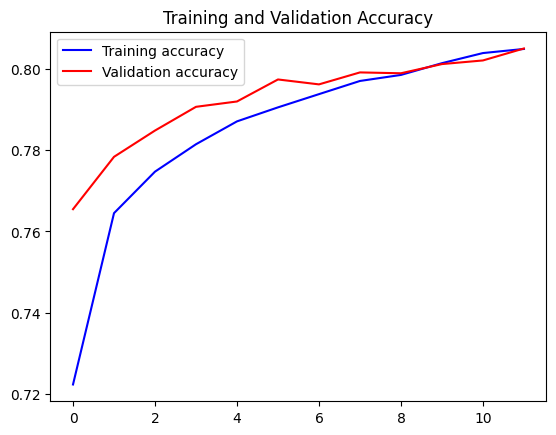

<Figure size 640x480 with 0 Axes>

In [45]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss,val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

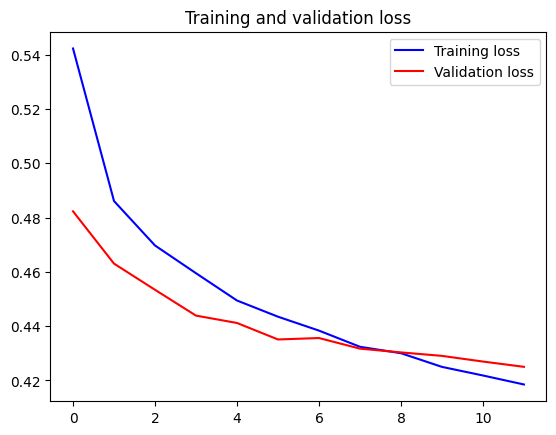

In [46]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#### Confusion Matrix 2

In [50]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [51]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [69]:
def predict(text, include_neutral=True):
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=60)
    score = training_model.predict([X_test])[0]
    label = decode_sentiment(score,include_neutral=include_neutral)
    return {label, float(score)}

In [88]:
predict('@AmericanAir just landed - 3hours Late Flight - and now we need to wait TWENTY MORE MINUTES for a gate! I have patience but none for incompetence.')

1/1 [==============================] - 0s 59ms/step


{0.2602196931838989, 'NEGATIVE'}

In [53]:
y_pred_1d = []
y_test_1d = list(df.sentiment)
scores = training_model.predict(X_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 14s 2s/step


In [56]:
import itertools

In [57]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df.sentiment.unique(), title="Confusion matrix")
plt.show()

313/313 [==============================] - 17s 53ms/step


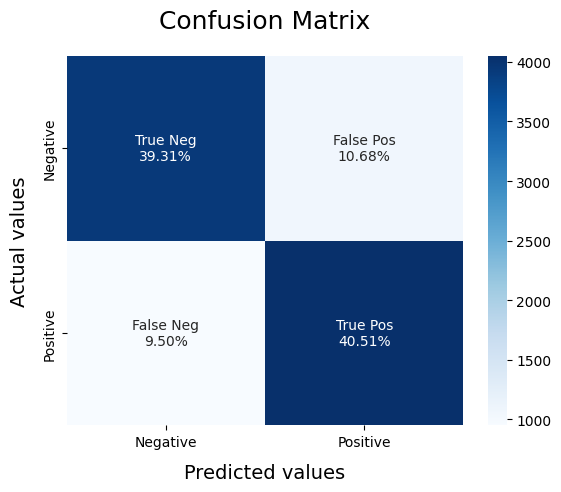

In [60]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4999
           1       0.79      0.81      0.80      5001

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



#### Saving the Model

In [63]:
word2vec_model.wv.save('W2V-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-Twitter-100-Trainable')

training_model.save('LSTM-Sentiment')
training_model.save_weights('Model Weights/weights')

INFO:tensorflow:Assets written to: LSTM-Sentiment\assets


INFO:tensorflow:Assets written to: LSTM-Sentiment\assets
